# CIFAR10 Image Classification Using LeNet

In this tutorial, we are going to walk through the logic in `lenet_cifar10_adversarial.py` shown below and provide step-by-step instructions.

In [1]:
!cat lenet_cifar10_adversarial.py

# Copyright 2019 The FastEstimator Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import tempfile

import tensorflow as tf

from fastestimator import Estimator, Network, Pipeline
from fastestimator.architecture import LeNet
from fastestimator.estimator.trace import Accuracy, ConfusionMatrix, ModelSaver
from fastestimator.network.loss import SparseCategoricalCrossentropy
from fastestimato

## Step 1: Prepare training and evaluation dataset, create FastEstimator `Pipeline`

`Pipeline` can take both data in memory and data in disk. In this example, we are going to use data in memory by loading data with `tf.keras.datasets.cifar10`

In [2]:
import tensorflow as tf

(x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.cifar10.load_data()
print("train image shape is {}".format(x_train.shape))
print("train label shape is {}".format(y_train.shape))
print("eval image shape is {}".format(x_eval.shape))
print("eval label shape is {}".format(y_eval.shape))

train image shape is (50000, 32, 32, 3)
train label shape is (50000, 1)
eval image shape is (10000, 32, 32, 3)
eval label shape is (10000, 1)


For in-memory data in `Pipeline`, the data format should be a nested dictionary like: {"mode1": {"feature1": numpy_array, "feature2": numpy_array, ...}, ...}. Each `mode` can be either `train` or `eval`, in our case, we have both `train` and `eval`.  `feature` is the feature name, in our case, we have `x` and `y`.

In [3]:
data = {"train": {"x": x_train, "y": y_train}, "eval": {"x": x_eval, "y": y_eval}}

Now we are ready to define `Pipeline`, we want to apply a `Minmax` online preprocessing to the image feature `x` for both training and evaluation:

In [4]:
import fastestimator as fe
from fastestimator.pipeline.processing import Minmax

pipeline = fe.Pipeline(batch_size=50, data=data, ops=Minmax(inputs="x", outputs="x"))

## Step 2: Prepare model, create FastEstimator `Network`

First, we have to define the network architecture in `tf.keras.Model` or `tf.keras.Sequential`, for a popular architecture like LeNet, FastEstimator has it implemented already in [fastestimator.architecture.lenet](https://github.com/fastestimator/fastestimator/blob/master/fastestimator/architecture/lenet.py).  After defining the architecture, users are expected to feed the architecture definition and its associated model name, optimizer and loss name (default to be 'loss') to `FEModel`.

In [5]:
from fastestimator.architecture import LeNet
from fastestimator.network.model import FEModel

model = FEModel(model_def=lambda: LeNet(input_shape=x_train.shape[1:], classes=10), model_name="LeNet", optimizer="adam")

We can now define a simple `Network`: given with a batch data with key `x` and `y`, we have to work our way to `loss` with series of operators.  `ModelOp` is an operator that contains a model.

In [6]:
from fastestimator.network.model import ModelOp
from fastestimator.network.loss import SparseCategoricalCrossentropy

simple_network = fe.Network(ops=[ModelOp(inputs="x", model=model, outputs="y_pred"), 
                                 SparseCategoricalCrossentropy(y_pred="y_pred", y_true="y", outputs="loss")])

One advantage of `FastEstimator`, though, is that it is easy to construct much more complicated graphs. In this example, we want to conduct training by generating adversarially perturbed images and training against them, since this has been shown to make neural networks more robust against future [attacks](https://arxiv.org/abs/1412.6572). To achieve this in `FastEstimator`, we start by running the input through the model op and computing loss as before, but this time the `ModelOp` has the track_input flag set to `True` in order to indicate that gradients should be computed with respect to the input image in addition to the model weights. The network then generates an adversarial sample image using the `AdversarialSample` augmentation module, and runs that image through the model. Finally, the model is trained using an average of the raw loss and adversarial loss. Note that the adversarial part of the process needs only be done during training (not evaluation) and so the `mode` of these final four operations is set to 'train'.  

In [7]:
from fastestimator.pipeline.augmentation import AdversarialSample, Average

pipeline2 = fe.Pipeline(batch_size=50, data=data, ops=Minmax(inputs="x", outputs="x"))
model2 = FEModel(model_def=lambda: LeNet(input_shape=x_train.shape[1:], classes=10), model_name="LeNet", optimizer="adam")

adversarial_network = fe.Network(ops=[
        ModelOp(inputs="x", model=model2, outputs="y_pred", track_input=True),
        SparseCategoricalCrossentropy(y_true="y", y_pred="y_pred", outputs="loss"),
        AdversarialSample(inputs=("loss", "x"), outputs="x_adverse", epsilon=0.01, mode="train"),
        ModelOp(inputs="x_adverse", model=model2, outputs="y_pred_adverse", mode="train"),
        SparseCategoricalCrossentropy(y_true="y", y_pred="y_pred_adverse", outputs="adverse_loss", mode="train"),
        Average(inputs=("loss", "adverse_loss"), outputs="loss", mode="train")
    ])

## Step 3: Configure training, create `Estimator`

During the training loop, we want to: 1) measure accuracy for data data 2) save the model with lowest valdiation loss. The `Trace` class is used for anything related to the training loop, and we will need to import the `Accuracy` and `ModelSaver` traces.

In [8]:
import tempfile
import os
from fastestimator.estimator.trace import Accuracy, ModelSaver

base_dir = tempfile.mkdtemp()
simple_save_dir = os.path.join(base_dir, 'simple')
adversarial_save_dir = os.path.join(base_dir, 'adverse')

simple_traces = [Accuracy(true_key="y", pred_key="y_pred", output_name='acc'),
                 ModelSaver(model_name="LeNet", save_dir=simple_save_dir, save_best=True)]

adversarial_traces = [Accuracy(true_key="y", pred_key="y_pred", output_name='acc'),
                      ModelSaver(model_name="LeNet", save_dir=adversarial_save_dir, save_best=True)]

Now we can define the `Estimator` and specify the training configuation. We will create estimators for both the simple and adversarial networks in order to compare their performances.

In [9]:
simple_estimator = fe.Estimator(network=simple_network, pipeline=pipeline, epochs=15, traces=simple_traces, log_steps=500)
adversarial_estimator = fe.Estimator(network=adversarial_network, pipeline=pipeline2, epochs=15, traces=adversarial_traces, log_steps=500)

## Step 4: Training

We'll start by training the regular network (takes about 7.7 minutes on a 2015 MacBookPro CPU - 2.5 GHz Intel Core i7). The network should attain an evaluation accuracy around 71%

In [10]:
simple_estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 0; LeNet_lr: 0.001; 
FastEstimator-Train: step: 0; loss: 2.3124847; 
FastEstimator-Train: step: 500; loss: 1.3299917; examples/sec: 1847.16; 
FastEstimator-ModelSaver: Saving model to /var/folders/sg/pck0wj4d27j2rwzg88n70trj5ysk83/T/tmpx1ir1w6d/simple/LeNet_best_loss.h5
FastEstimator-Eval: step: 1000; epoch: 0; loss: 1.2784046; min_loss: 1.2784046; since_best_loss: 0; acc: 0.5462; 
FastEstimator-Train: step: 1000; loss: 1.1689698; examples/sec: 1830.1; 
FastEstimator-Train: step: 1500; loss: 0.9811843; examples/sec: 1720.13; 
Fa

Next we train the network adversarially. This process takes longer (about 17 minutes) since it requires two different gradient computations and model evaluations per forward step rather than one. It is also slower to converge since the training process is more difficult, though should also get to around 71% evaluation accuracy.

In [11]:
adversarial_estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



W0918 14:54:45.685590 4569220544 deprecation.py:323] From /Users/212582149/Development/Healthcare/FE/fastestimator/venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


FastEstimator-Start: step: 0; LeNet_lr: 0.001; 
FastEstimator-Train: step: 0; loss: 2.3298383; 
FastEstimator-Train: step: 500; loss: 1.8669537; examples/sec: 738.15; 
FastEstimator-ModelSaver: Saving model to /var/folders/sg/pck0wj4d27j2rwzg88n70trj5ysk83/T/tmpx1ir1w6d/adverse/LeNet_best_loss.h5
FastEstimator-Eval: step: 1000; epoch: 0; loss: 1.4251435; min_loss: 1.4251435; since_best_loss: 0; acc: 0.482; 
FastEstimator-Train: step: 1000; loss: 1.8473295; examples/sec: 744.19; 
FastEstimator-Train: step: 1500; loss: 1.313486; examples/sec: 749.07; 
FastEstimator-ModelSaver: Saving model to /var/folders/sg/pck0wj4d27j2rwzg88n70trj5ysk83/T/tmpx1ir1w6d/adverse/LeNet_best_loss.h5
FastEstimator-Eval: step: 2000; epoch: 1; loss: 1.2645028; min_loss: 1.2645028; since_best_loss: 0; acc: 0.5524; 
FastEstimator-Train: step: 2000; loss: 1.3079686; examples/sec: 759.75; 
FastEstimator-Train: step: 2500; loss: 1.3571646; examples/sec: 763.29; 
FastEstimator-ModelSaver: Saving model to /var/folders

## Step 5: Inferencing and Adversarial Attacks

After training, the model is saved to a temporary folder. We can load the model from file and do inferencing on a sample image.

In [12]:
simple_model_path = os.path.join(simple_save_dir, 'LeNet_best_loss.h5')
simple_model = tf.keras.models.load_model(simple_model_path, compile=False)

adversarial_model_path = os.path.join(adversarial_save_dir, 'LeNet_best_loss.h5')
adversarial_model = tf.keras.models.load_model(adversarial_model_path, compile=False)

Lets consider a few images from the evaluation dataset and see how the networks respond to adversarial attacks

True Labels:                [cat     , ship    , ship    , airplane, frog    , frog    , car     , frog    , cat     , car     ]
Simple Model Predicts:      [cat     , ship    , ship    , airplane, frog    , frog    , car     , frog    , cat     , car     ] (71.7% accuracy over 10000 images)
Adversarial Model Predicts: [cat     , ship    , ship    , airplane, frog    , frog    , car     , deer    , cat     , car     ] (69.9% accuracy over 10000 images)


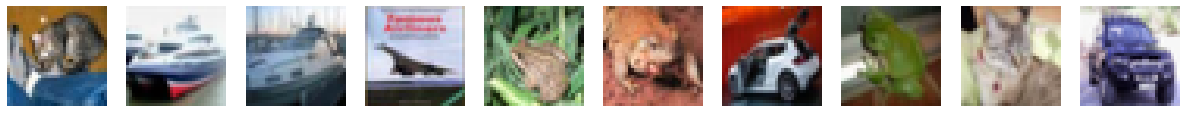

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from fastestimator.util.vis_util import show_image
from fastestimator.pipeline.processing import Minmax

minmax = Minmax()
num_vis = 10
num_samples = 10000

fig, axis = plt.subplots(1, num_vis, figsize=(21, 3))
sample_images = tf.stack([minmax.forward(tf.constant(x), {}) for x in x_eval[0:num_samples]])
sample_labels = tf.constant(y_eval[0:num_samples])
for idx in range(num_vis):
    show_image(axis[idx], sample_images[idx])

class_dictionary = {
    0: "airplane", 1: "car", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

print("True Labels:                [{}]".format(
    ', '.join(['{:<8}' for _ in range(num_vis)])).format(*[class_dictionary[x[0].numpy()] for x in sample_labels][0:num_vis]))
simple_prediction_score = simple_model.predict(sample_images)
simple_accuracy = 1.0 - np.sum(np.not_equal(np.argmax(simple_prediction_score, axis=1), tf.reshape(sample_labels, (num_samples,)))) / num_samples
print("Simple Model Predicts:      [{}] ({:2.1%} accuracy over {} images)".format(
    ', '.join(['{:<8}' for _ in range(num_vis)]), simple_accuracy, num_samples).format(
    *[class_dictionary[x] for x in np.argmax(simple_prediction_score, axis=1)][0:num_vis]))
adversarial_prediction_score = adversarial_model.predict(sample_images)
adversarial_accuracy = 1.0 - np.sum(np.not_equal(np.argmax(adversarial_prediction_score, axis=1), tf.reshape(sample_labels, (num_samples,)))) / num_samples
print("Adversarial Model Predicts: [{}] ({:2.1%} accuracy over {} images)".format(
    ', '.join(['{:<8}' for _ in range(num_vis)]), adversarial_accuracy, num_samples).format(
    *[class_dictionary[x] for x in np.argmax(adversarial_prediction_score, axis=1)][0:num_vis]))

As we can see, both the simple model and the one trained against adversarial samples correctly identify a majority of the evaluation images, with a population accuracy around 70% each. Now, to create the adversarial versions of the images, we'll simulate the adversarial augmentation object


In [14]:
def attack(images, model, ground_truth, epsilon):
    loss_obj = tf.losses.SparseCategoricalCrossentropy(reduction='none')
    with tf.GradientTape() as tape:
        tape.watch(images)
        pred = model(images, training=False)
        loss = loss_obj(ground_truth, pred)
    gradients = tape.gradient(loss, images)
    adverse_images = tf.clip_by_value(images + epsilon * tf.sign(gradients),
                                      tf.reduce_min(images),
                                      tf.reduce_max(images))
    return adverse_images

First we will generate adversarial images by inspecting the gradients of the simple model, and see how well the two models can resist the attack

True Labels:                [cat     , ship    , ship    , airplane, frog    , frog    , car     , frog    , cat     , car     ]
Simple Model Predicts:      [frog    , ship    , truck   , ship    , deer    , frog    , airplane, deer    , bird    , truck   ] (31.9% accuracy over 10000 images)
Adversarial Model Predicts: [cat     , ship    , ship    , airplane, deer    , frog    , truck   , deer    , cat     , car     ] (65.2% accuracy over 10000 images)


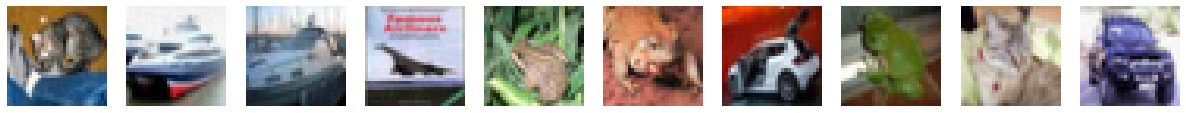

In [21]:
adverse_images = attack(sample_images, simple_model, sample_labels, 0.01)

fig, axis = plt.subplots(1, num_vis, figsize=(21, 3))
for idx in range(num_vis):
    show_image(axis[idx], adverse_images[idx])
    
print("True Labels:                [{}]".format(
    ', '.join(['{:<8}' for _ in range(num_vis)])).format(*[class_dictionary[x[0].numpy()] for x in sample_labels][0:num_vis]))
simple_prediction_score = simple_model.predict(adverse_images)
simple_accuracy_w = 1.0 - np.sum(np.not_equal(np.argmax(simple_prediction_score, axis=1), tf.reshape(sample_labels, (num_samples,)))) / num_samples
print("Simple Model Predicts:      [{}] ({:2.1%} accuracy over {} images)".format(
    ', '.join(['{:<8}' for _ in range(num_vis)]), simple_accuracy_w, num_samples).format(
    *[class_dictionary[x] for x in np.argmax(simple_prediction_score, axis=1)][0:num_vis]))
adversarial_prediction_score = adversarial_model.predict(adverse_images)
adversarial_accuracy_b = 1.0 - np.sum(np.not_equal(np.argmax(adversarial_prediction_score, axis=1), tf.reshape(sample_labels, (num_samples,)))) / num_samples
print("Adversarial Model Predicts: [{}] ({:2.1%} accuracy over {} images)".format(
    ', '.join(['{:<8}' for _ in range(num_vis)]), adversarial_accuracy_b, num_samples).format(
    *[class_dictionary[x] for x in np.argmax(adversarial_prediction_score, axis=1)][0:num_vis]))

Even though these adversarially attacked images look basically the same as the original images, the accuracy of the traditionally trained model has dropped to 31.9%. The adversarially trained model also sees a reduction in accuracy, but only to 65.2%. It is, however, an incomplete/unfair comparison since the attack is white-box against the simple network but black-box against the adversarially trained network. Let's now generate adversarial images using the adversarially trainined network instead and see how well the models resist the attack

True Labels:                [cat     , ship    , ship    , airplane, frog    , frog    , car     , frog    , cat     , car     ]
Simple Model Predicts:      [cat     , ship    , ship    , airplane, deer    , frog    , car     , deer    , cat     , car     ] (61.6% accuracy over 10000 images)
Adversarial Model Predicts: [cat     , ship    , airplane, airplane, deer    , frog    , truck   , deer    , cat     , truck   ] (49.1% accuracy over 10000 images)


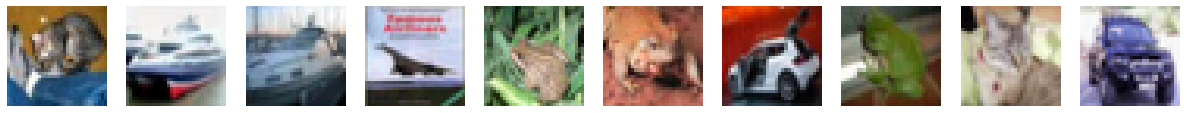

In [22]:
adverse_images = attack(sample_images, adversarial_model, sample_labels, 0.01)

fig, axis = plt.subplots(1, num_vis, figsize=(21, 3))
for idx in range(num_vis):
    show_image(axis[idx], adverse_images[idx])
    
print("True Labels:                [{}]".format(
    ', '.join(['{:<8}' for _ in range(num_vis)])).format(*[class_dictionary[x[0].numpy()] for x in sample_labels][0:num_vis]))
simple_prediction_score = simple_model.predict(adverse_images)
simple_accuracy_b = 1.0 - np.sum(np.not_equal(np.argmax(simple_prediction_score, axis=1), tf.reshape(sample_labels, (num_samples,)))) / num_samples
print("Simple Model Predicts:      [{}] ({:2.1%} accuracy over {} images)".format(
    ', '.join(['{:<8}' for _ in range(num_vis)]), simple_accuracy_b, num_samples).format(
    *[class_dictionary[x] for x in np.argmax(simple_prediction_score, axis=1)][0:num_vis]))
adversarial_prediction_score = adversarial_model.predict(adverse_images)
adversarial_accuracy_w = 1.0 - np.sum(np.not_equal(np.argmax(adversarial_prediction_score, axis=1), tf.reshape(sample_labels, (num_samples,)))) / num_samples
print("Adversarial Model Predicts: [{}] ({:2.1%} accuracy over {} images)".format(
    ', '.join(['{:<8}' for _ in range(num_vis)]), adversarial_accuracy_w, num_samples).format(
    *[class_dictionary[x] for x in np.argmax(adversarial_prediction_score, axis=1)][0:num_vis]))

Under this attack, the accuracy of the traditionally trained model has dropped to 61.6%. The adversarially trained model meanwhile has its performance reduced to 49.1%. While the raw adversarial accuracy here is now lower than the simple model, the performance loss is significantly less than it was for the simple model in the previous attack. To properly compare the models, the white-box and black-box attacks should be compared pairwise against one another:

In [27]:
print("White box attack vs simple network:      {:2.2%} accuracy".format(simple_accuracy_w - simple_accuracy))
print("White box attack vs adversarial network: {:2.2%} accuracy".format(adversarial_accuracy_w - simple_accuracy))
print()
print("Black box attack vs simple network:      {:2.2%} accuracy".format(simple_accuracy_b - simple_accuracy))
print("Black box attack vs adversarial network: {:2.2%} accuracy".format(adversarial_accuracy_b - simple_accuracy))

White box attack vs simple network:      -39.78% accuracy
White box attack vs adversarial network: -22.67% accuracy

Black box attack vs simple network:      -10.09% accuracy
Black box attack vs adversarial network: -6.51% accuracy


Adversarially attacking the simple network using white-box gradient analysis cost nearly 40 percentage points of accuracy. The same attack conducted against the adversarially trained network cost only around 23 percentage points. Likewise, a blackbox attack against the simple network cost 10 percentage points versus 6.5 against the adversarial network. This shows that the adversarial training process makes a network approximately twice as robust against future adversarial attacks. Whether such benefits are worth the increased training time would, of course, depend on the model deployment use-case. 